In [2]:
import pandas_datareader as pdr
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Collecting Data

In [3]:
startdate = datetime.datetime(2000, 10, 1)
enddate = datetime.datetime(2020, 5, 7)

ticker = pdr.get_data_yahoo(['KN'], start=startdate, end=enddate)

Attributes  Adj Close      Close       High    Low       Open   Volume
Symbols            KN         KN         KN     KN         KN       KN
Date                                                                  
2014-02-14  28.690001  28.690001  32.500000  28.00  32.500000   479500
2014-02-18  28.340000  28.340000  29.639999  28.00  28.990000   351800
2014-02-19  28.370001  28.370001  30.180000  27.58  28.440001  1133000
2014-02-20  29.090000  29.090000  29.360001  28.15  28.150000   580400
2014-02-21  29.000000  29.000000  29.400000  28.74  29.400000   641300

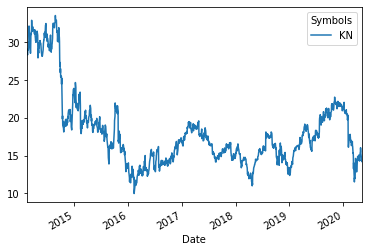

In [4]:
ticker['Adj Close'].plot()
ticker.head()

# Basic analysis

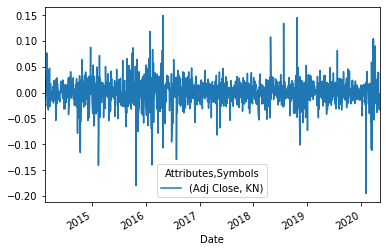

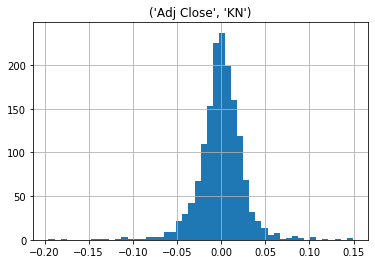

In [5]:
#Returns
daily_close_px = ticker[['Adj Close']]
daily_pct_change = daily_close_px.pct_change()

# Show retrun and distribution
daily_pct_change.plot()
daily_pct_change.hist(bins=50, sharex=True)

plt.show()

In [6]:
#Volatility
min_periods = 75

# Calculate the volatility
vol = daily_pct_change.rolling(min_periods).std() * np.sqrt(min_periods) 
vol.plot()

# Moving average strategy

In [7]:
# Creat signals
short_window = 40
long_window = 100


signals = pd.DataFrame(index=ticker.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = ticker['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = ticker['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
print(signals)

            signal  short_mavg  long_mavg  positions
Date                                                
2014-02-14     0.0   28.690001  28.690001        NaN
2014-02-18     0.0   28.515000  28.515000        0.0
2014-02-19     0.0   28.466667  28.466667        0.0
2014-02-20     0.0   28.622500  28.622500        0.0
2014-02-21     0.0   28.698000  28.698000        0.0
...            ...         ...        ...        ...
2020-05-01     0.0   14.128250  17.427600        0.0
2020-05-04     0.0   14.092500  17.357300        0.0
2020-05-05     0.0   14.079000  17.289400        0.0
2020-05-06     0.0   14.052000  17.214800        0.0
2020-05-07     0.0   14.035000  17.137600        0.0

[1568 rows x 4 columns]


# Show signals

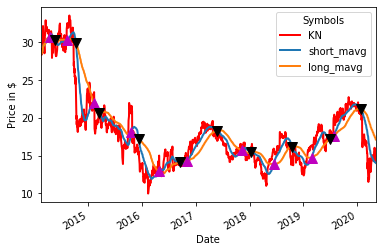

In [8]:
# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
ticker['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

# Backtest

In [9]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['KN'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(ticker['Adj Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(ticker['Adj Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(ticker['Adj Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio.head(5))

             KN  holdings      cash     total  returns
Date                                                  
2014-02-14  0.0       0.0  100000.0  100000.0      NaN
2014-02-18  0.0       0.0  100000.0  100000.0      0.0
2014-02-19  0.0       0.0  100000.0  100000.0      0.0
2014-02-20  0.0       0.0  100000.0  100000.0      0.0
2014-02-21  0.0       0.0  100000.0  100000.0      0.0


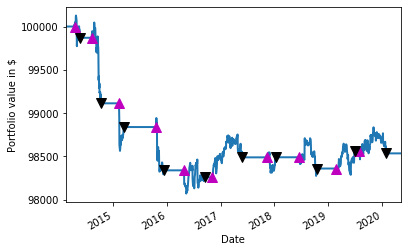

In [10]:
# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

# Get indicators

In [11]:
# Isolate the returns of your strategy
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print("Sharpe ratio:",sharpe_ratio)

Sharpe ratio: -0.498460317188102


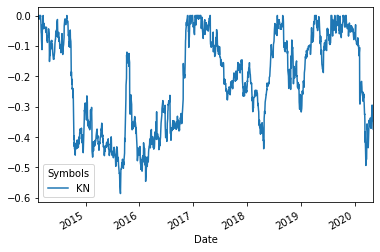

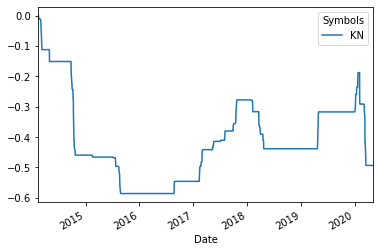

In [13]:
# Define a trailing 252 trading day window
window = 252

# Calculate the max drawdown in the past window days for each day 
rolling_max = ticker['Adj Close'].rolling(window, min_periods=1).max()
daily_drawdown = ticker['Adj Close']/rolling_max - 1.0

# Calculate the minimum (negative) daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Plot the results
daily_drawdown.plot(label='Adj Close')
max_daily_drawdown.plot(label='Drawdown')

# Show the plot
plt.show()

# Ideas

- do the process on all the CAC40 indices
- optimize the sma on a period and test on another
- other strategies : predict courses
- adpat to a library : quantopiant